In [1]:
from google.colab import files
files.upload()  # Upload your kaggle.json file
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the Facial Expression Dataset
!kaggle datasets download -d astraszab/facial-expression-dataset-image-folders-fer2013
# Unzip the downloaded dataset
!unzip facial-expression-dataset-image-folders-fer2013.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/data/train/6/28451.png  
  inflating: dataset/data/train/6/28452.png  
  inflating: dataset/data/train/6/28467.png  
  inflating: dataset/data/train/6/28471.png  
  inflating: dataset/data/train/6/28472.png  
  inflating: dataset/data/train/6/28478.png  
  inflating: dataset/data/train/6/2848.png  
  inflating: dataset/data/train/6/28480.png  
  inflating: dataset/data/train/6/28484.png  
  inflating: dataset/data/train/6/28485.png  
  inflating: dataset/data/train/6/28493.png  
  inflating: dataset/data/train/6/28499.png  
  inflating: dataset/data/train/6/28507.png  
  inflating: dataset/data/train/6/28517.png  
  inflating: dataset/data/train/6/28519.png  
  inflating: dataset/data/train/6/28520.png  
  inflating: dataset/data/train/6/28524.png  
  inflating: dataset/data/train/6/28530.png  
  inflating: dataset/data/train/6/28531.png  
  inflating: dataset/data/train/6/28535.png  
  inflating: dataset/data/trai

In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Set up paths
train_dir = 'dataset/data/train'
test_dir = 'dataset/data/test'

In [9]:
label_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [5]:
# Image parameters
IMG_SIZE = (48, 48)  # Resize all images to 48x48
BATCH_SIZE = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only rescale for testing data
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [6]:
# Load the VGG16 model without the top layers (pre-trained on ImageNet)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze VGG16 layers to prevent training
for layer in vgg_base.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Build & Train the ANN Model

In [7]:
# Build the model
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer for 7 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 75s 77ms/step - accuracy: 0.2436 - loss: 1.8331 - val_accuracy: 0.3305 - val_loss: 1.6809
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.2889 - loss: 1.7406 - val_accuracy: 0.3427 - val_loss: 1.6587
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3041 - loss: 1.7207 - val_accuracy: 0.3416 - val_loss: 1.6408
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.3108 - loss: 1.7095 - val_accuracy: 0.3525 - val_loss: 1.6365
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - accuracy: 0.3169 - loss: 1.7025 - val_accuracy: 0.3433 - val_loss: 1.6414
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.3205 - loss: 1.7026 - val_accuracy: 0.3547 - val_loss: 1.6317
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.3239 - loss: 1.6891 - val_accuracy: 0.3636 - val_loss: 1.6105
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.3288 - loss: 1.6916 - val_accurac

## Evaluate the Model

Test Accuracy: 0.38
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.13      0.04      0.06       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.15      0.05      0.07       528
       Happy       0.26      0.54      0.35       879
         Sad       0.17      0.06      0.09       594
    Surprise       0.13      0.12      0.13       416
     Neutral       0.18      0.23      0.20       626

    accuracy                           0.21      3589
   macro avg       0.14      0.15      0.13      3589
weighted avg       0.18      0.21      0.17      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


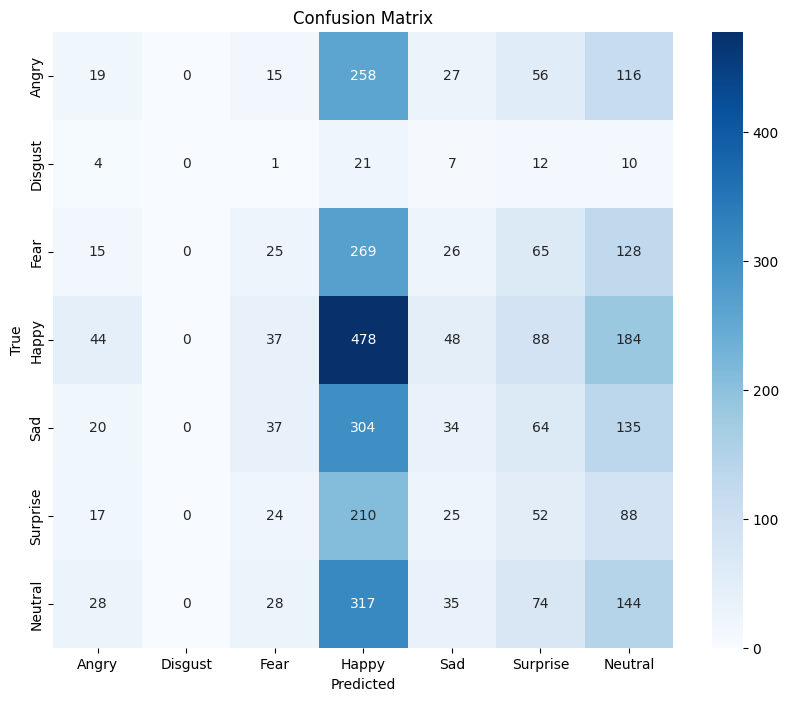

In [10]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict on test data
test_generator.reset()
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Map numeric labels back to emotions
y_true_labels = [label_mapping[label] for label in y_true]
y_pred_labels = [label_mapping[label] for label in y_pred]

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_mapping.values())))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(),
            yticklabels=label_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


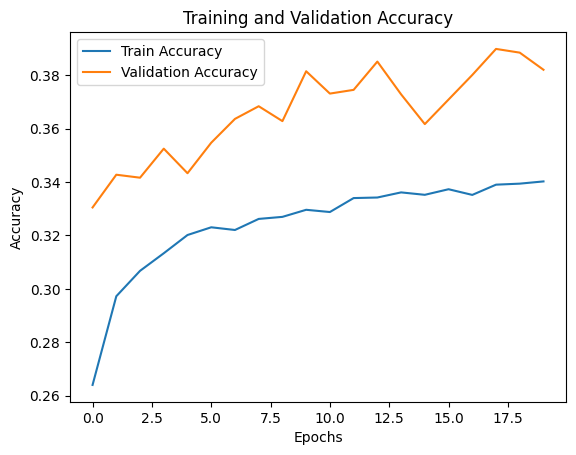

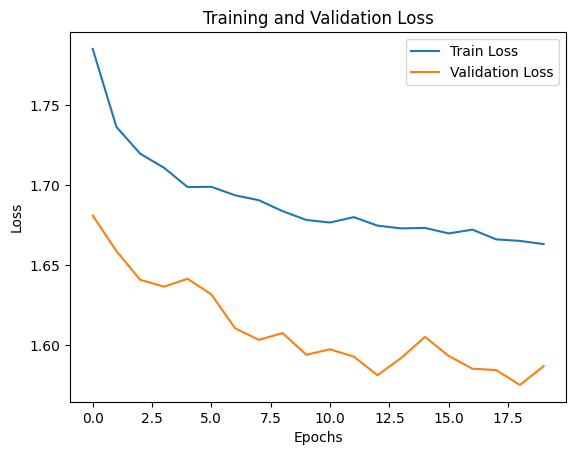

In [11]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, label_mapping, generator):
    """
    Predict the sentiment (emotion) of a single image and display its original and predicted labels.

    Parameters:
    - model: Trained Keras model.
    - image_path: Path to the image to predict.
    - label_mapping: Dictionary mapping numeric labels to emotion strings.
    - generator: Data generator (for preprocessing rules).

    Returns:
    - None: Displays the image, original label, and predicted label.
    """
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # Load and preprocess the image
    img = load_img(image_path, target_size=generator.target_size)  # Resize image
    img_array = img_to_array(img) / 255.0  # Convert to array and normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the emotion
    predictions = model.predict(img_array)
    predicted_label_index = np.argmax(predictions)
    predicted_label = label_mapping[predicted_label_index]

    # Display the image with predicted and true labels
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

    return predicted_label_index

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


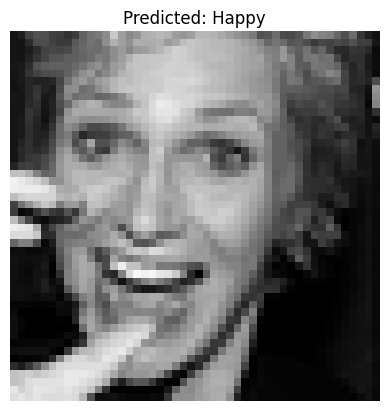

True Label: Happy
Predicted Label: Happy


In [18]:
# Example usage for a single test image
import os

# Path to an example image from the test dataset
example_image_path = os.path.join(test_dir, '3', '32307.png')

# Original label (based on folder name)
true_label_index = int(os.path.basename(os.path.dirname(example_image_path)))
true_label = label_mapping[true_label_index]

# Predict the label
predicted_label_index = predict_single_image(model, example_image_path, label_mapping, test_generator)
predicted_label = label_mapping[predicted_label_index]

# Display results
print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")